## Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import os

### Feature Engineering

This phase will transform our features to provide our model with data in a more digestible form. Skewed numericals will have to be normalized, high cardinality categorical features will need to be grouped and some numeric columns will need to be binned. Since our initial model will be using a distance based algorithm, it is important to normalize highly skewed features to lessen the influence of extreme values. To avoid overfitting we must group our high cardinality features and for extremely skewed features we use binning as an alternative to transforming. Our subsequent models will process faster, be less prone to overfitting and will better understand influences that determine cancellations.

In [2]:
# Read in clean data
hotels = pd.read_csv('data/hotels_clean.csv', index_col=0)

In [3]:
# Map months of the year to numeric values to create arrival date column for exploration
d = {'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12, 'January':1, 'February':2, 'March':3, 'April':4, 'May': 5, 'June':6}
hotels.arrival_date_month = hotels.arrival_date_month.map(d)

In [4]:
hotels.info() ### What happened to the kids column??

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119386 entries, 0 to 119389
Data columns (total 33 columns):
hotel                             119386 non-null object
is_canceled                       119386 non-null int64
lead_time                         119386 non-null int64
arrival_date_year                 119386 non-null int64
arrival_date_month                119386 non-null int64
arrival_date_week_number          119386 non-null int64
arrival_date_day_of_month         119386 non-null int64
stays_in_weekend_nights           119386 non-null int64
stays_in_week_nights              119386 non-null int64
adults                            119386 non-null int64
children                          119386 non-null int64
babies                            119386 non-null int64
meal                              119386 non-null object
country                           119386 non-null object
market_segment                    119386 non-null object
distribution_channel              119386 non-

In [5]:
# read in results dataframes from statistical analysis
chi_square_results = pd.read_csv('data/chi_square_results.csv', index_col=0)
t_stat_results = pd.read_csv('data/t_stat_results.csv', index_col=0)

In [7]:
# Use results from statistical analysis to form features list
cat_features = chi_square_results.index.to_list()
num_features = t_stat_results[t_stat_results['result'] != 'Ind (fail to reject H0)'].index.to_list()
features = cat_features + num_features

In [81]:
# Add label to features to be removed later on when the data is split
features.append('is_canceled')

In [82]:
# dataframe for feature engineering
data = hotels[features]

In [83]:
data.describe(include='O').T

count unique         top    freq
hotel                 119386      2  City Hotel   79326
country               119386    178         PRT   48587
market_segment        119386      7   Online TA   56476
distribution_channel  119386      5       TA/TO   97869
reserved_room_type    119386     10           A   85993
customer_type         119386      4   Transient   89612
kids                  119386      2     no_kids  110056

In [84]:
data.describe(exclude='O').T

count         mean         std     min  \
lead_time                       119386.0   104.014474  106.863548     0.0   
arrival_date_year               119386.0  2016.156585    0.707464  2015.0   
arrival_date_month                   0.0          NaN         NaN     NaN   
arrival_date_week_number        119386.0    27.165170   13.605104     1.0   
arrival_date_day_of_month       119386.0    15.798511    8.780825     1.0   
babies                          119386.0     0.007790    0.089334     0.0   
is_repeated_guest               119386.0     0.031913    0.175770     0.0   
previous_cancellations          119386.0     0.087121    0.844350     0.0   
previous_bookings_not_canceled  119386.0     0.137102    1.497462     0.0   
agent                           119386.0    74.829955  107.143125     0.0   
company                         119386.0    10.775518   53.944751     0.0   
days_in_waiting_list            119386.0     2.321227   17.595011     0.0   
adr                             119386.0   101.832832   50.535246     0.0   
is_canceled                     119386.0     0.370412    0.482917     0.0   

                                    25%      50%     75%     max  
lead_time                         18.00    69.00   160.0   737.0  
arrival_date_year               2016.00  2016.00  2017.0  2017.0  
arrival_date_month                  NaN      NaN     NaN     NaN  
arrival_date_week_number          16.00    28.00    38.0    53.0  
arrival_date_day_of_month          8.00    16.00    23.0    31.0  
babies                             0.00     0.00     0.0     2.0  
is_repeated_guest                  0.00     0.00     0.0     1.0  
previous_cancellations             0.00     0.00     0.0    26.0  
previous_bookings_not_canceled     0.00     0.00     0.0    72.0  
agent                              7.00     9.00   152.0   535.0  
company                            0.00     0.00     0.0   543.0  
days_in_waiting_list               0.00     0.00     0.0   391.0  
adr                               69.29    94.59   126.0  5400.0  
is_canceled                        0.00     0.00     1.0     1.0

### Group categories into binary representations

In [85]:
data = (data.assign(babies = lambda df: df.babies.map(
                    lambda babies: '1' if babies > 0 else '0')))

In [86]:
# Drop 'Undefined' and 'GDS' to avoid overfitting on not well represented categories
drop_index = data[(data.distribution_channel == 'Undefined') | (data.distribution_channel == 'GDS')].index

data.drop(drop_index, inplace=True)

Move step above to data cleaning (if possible so it doesnt disrupt other work)

In [87]:
# apply sqrt tranformation for daily rate, skewness reduced to -0.38
data['adr_sqrt'] = np.sqrt(data.adr)
data.drop(['adr'], axis=1, inplace=True)
# replace NAN from negative adr value
data.replace(np.nan, 0, inplace=True)

In [88]:
# apply sqrt tranformation for daily rate, skewness reduced to -0.38
data['previous_cancellations_sqrt'] = np.sqrt(data.previous_cancellations)
data.drop(['previous_cancellations'], axis=1, inplace=True)
# replace NAN values
data.replace(np.nan, 0, inplace=True)

In [89]:
# apply sqrt tranformation for daily rate, skewness reduced to -0.38
data['lead_time_sqrt'] = np.sqrt(data.lead_time)
data.drop(['lead_time'], axis=1, inplace=True)
# replace NAN values
data.replace(np.nan, 0, inplace=True)

### Group low-frequency entries into 'other'

In [90]:
data[['country', 'market_segment', 'agent']] = data[['country', 'market_segment', 'agent']]\
                                                    .where(data[['country', 'market_segment', 'agent']]\
                                                    .apply(lambda x: x.map(x.value_counts()))>=1000, "other")

In [91]:
frequencies = data['company'].value_counts()

condition = frequencies<=100 
mask_obs = frequencies[condition].index
mask_dict = dict.fromkeys(mask_obs, 'other')

data['company'] = data['company'].replace(mask_dict) 

### Group numeric into quantiles

In [92]:
bins = [0, 50, 100, 150, 200, np.inf]
labels = ['1-50', '51-100', '101-150', '151-200', '>200']
data['days_in_waiting_list_binned'] = pd.cut(data['days_in_waiting_list'], bins, labels=labels)
data.replace(np.nan, 'zero_days_waiting', inplace=True)

In [93]:
bins = [0, 1, 2, 3, 4, 5, np.inf]
labels = ['1', '2', '3', '4', '5', '>5']
data['previous_bookings_not_canceled_binned'] = pd.cut(data['previous_bookings_not_canceled'], bins, labels=labels)
data.replace(np.nan, '0', inplace=True)

In [94]:
# drop original columns before binning
data_final = data.drop(['days_in_waiting_list', 'previous_bookings_not_canceled'], axis=1)

In [95]:
# make repeated guest categorical
data.is_repeated_guest = data.is_repeated_guest.astype('object')

In [96]:
data_final.describe(exclude='O').T

count         mean        std     min  \
arrival_date_year            119190.0  2016.156137   0.707627  2015.0   
arrival_date_month           119190.0     0.000000   0.000000     0.0   
arrival_date_week_number     119190.0    27.167254  13.601657     1.0   
arrival_date_day_of_month    119190.0    15.799119   8.780242     1.0   
is_repeated_guest            119190.0     0.031941   0.175843     0.0   
is_canceled                  119190.0     0.370694   0.482993     0.0   
adr_sqrt                     119190.0     9.764296   2.542041     0.0   
previous_cancellations_sqrt  119190.0     0.061061   0.289026     0.0   
lead_time_sqrt               119190.0     8.660492   5.398810     0.0   

                                     25%          50%          75%  \
arrival_date_year            2016.000000  2016.000000  2017.000000   
arrival_date_month              0.000000     0.000000     0.000000   
arrival_date_week_number       16.000000    28.000000    38.000000   
arrival_date_day_of_month       8.000000    16.000000    23.000000   
is_repeated_guest               0.000000     0.000000     0.000000   
is_canceled                     0.000000     0.000000     1.000000   
adr_sqrt                        8.306624     9.721111    11.224972   
previous_cancellations_sqrt     0.000000     0.000000     0.000000   
lead_time_sqrt                  4.242641     8.306624    12.688578   

                                     max  
arrival_date_year            2017.000000  
arrival_date_month              0.000000  
arrival_date_week_number       53.000000  
arrival_date_day_of_month      31.000000  
is_repeated_guest               1.000000  
is_canceled                     1.000000  
adr_sqrt                       73.484692  
previous_cancellations_sqrt     5.099020  
lead_time_sqrt                 27.147744

In [97]:
data_final.describe(include='O').T

count unique                top  \
hotel                                  119190      2         City Hotel   
country                                119190     16                PRT   
market_segment                         119190      6          Online TA   
distribution_channel                   119190      3              TA/TO   
reserved_room_type                     119190     10                  A   
customer_type                          119190      4          Transient   
kids                                   119190      2            no_kids   
babies                                 119190      2                  0   
agent                                  119190     16                  9   
company                                119190     13                  0   
days_in_waiting_list_binned            119190      6  zero_days_waiting   
previous_bookings_not_canceled_binned  119190      7                  0   

                                         freq  
hotel                                   79131  
country                                 48563  
market_segment                          56328  
distribution_channel                    97869  
reserved_room_type                      85838  
customer_type                           89418  
kids                                   109861  
babies                                 118275  
agent                                   31959  
company                                112394  
days_in_waiting_list_binned            115492  
previous_bookings_not_canceled_binned  115572

In [98]:
data_final.head()

hotel country market_segment distribution_channel  \
0  Resort Hotel     PRT         Direct               Direct   
1  Resort Hotel     PRT         Direct               Direct   
2  Resort Hotel     GBR         Direct               Direct   
3  Resort Hotel     GBR      Corporate            Corporate   
4  Resort Hotel     GBR      Online TA                TA/TO   

  reserved_room_type customer_type     kids  arrival_date_year  \
0                  C     Transient  no_kids               2015   
1                  C     Transient  no_kids               2015   
2                  A     Transient  no_kids               2015   
3                  A     Transient  no_kids               2015   
4                  A     Transient  no_kids               2015   

   arrival_date_month  arrival_date_week_number  ...  babies  \
0                 0.0                        27  ...       0   
1                 0.0                        27  ...       0   
2                 0.0                        27  ...       0   
3                 0.0                        27  ...       0   
4                 0.0                        27  ...       0   

  is_repeated_guest  agent company is_canceled  adr_sqrt  \
0                 0      0       0           0  0.000000   
1                 0      0       0           0  0.000000   
2                 0      0       0           0  8.660254   
3                 0  other       0           0  8.660254   
4                 0    240       0           0  9.899495   

   previous_cancellations_sqrt  lead_time_sqrt  days_in_waiting_list_binned  \
0                          0.0       18.493242            zero_days_waiting   
1                          0.0       27.147744            zero_days_waiting   
2                          0.0        2.645751            zero_days_waiting   
3                          0.0        3.605551            zero_days_waiting   
4                          0.0        3.741657            zero_days_waiting   

  previous_bookings_not_canceled_binned  
0                                     0  
1                                     0  
2                                     0  
3                                     0  
4                                     0  

[5 rows x 21 columns]

### Apply dummy coding techinques

In [99]:
# Dummy coding for col in dummy_cols
dummy_data = data_final
dummy_cols = ['distribution_channel', 'hotel', 'kids', 'customer_type', 'babies', 'is_repeated_guest']
transformed = []
for col in dummy_cols:
    dummy = pd.get_dummies(dummy_data[col])
    dummy_data = pd.concat([dummy_data,dummy], axis=1)

In [100]:
# drop original columns before dummy-ing
dummy_data.drop(dummy_cols, axis=1, inplace=True)

In [101]:
from sklearn.preprocessing import LabelEncoder
# For higher cardinality columns, employ label encoder 
enc_cols = ['market_segment', 'agent', 'country', 'reserved_room_type', 'company', 'previous_bookings_not_canceled_binned', 'days_in_waiting_list_binned']
for col in enc_cols:
    data_list = dummy_data[col].to_list()
    values = np.array(data_list)
    # initialize labelencoder, fit and transform
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    transformed.append(integer_encoded)
    # Drop country column and replace with encoded 
    dummy_data.drop(col, axis = 1, inplace = True)
    dummy_data[col] = integer_encoded

### Split the Data into train and test

In [102]:
from sklearn.model_selection import train_test_split
# Split data into features and label
# features X
X = dummy_data.drop('is_canceled', axis=1)
        
# Label y
y = dummy_data['is_canceled']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=3)

## Machine Learning

### Logistic regression

We start with a basic logistic regression model pipped with a standard scalar to allow our features to be more digestible and comparable for the model algorithm. An appropriate measurement will be accuracy, which gives the percentage of correct predictions, and the area under the ROC curve which measures how well the model can differentiate between classes. The scores we receive from these measurements in our logistic regression classification model will be used as a benchmark for improvement.

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#scaler in pipeline object, use logreg algorithm
steps = [('scaler', StandardScaler()), \
         ('logreg', LogisticRegression())]
pipeline = Pipeline(steps)

# fit on training set
logreg_scaled = pipeline.fit(X_train, y_train)
# predict on test set
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.7565231982548871

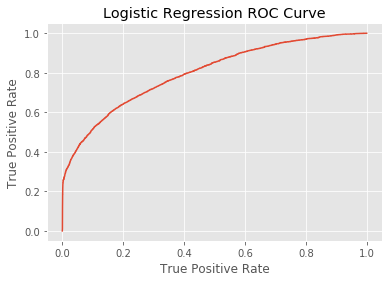

In [104]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve

# plotting the ROC curve
y_pred_prob = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('True Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [105]:
print(roc_auc_score(y_test, y_pred_prob))

0.7990993466613656


> Our benchmark is a ~76% accuracy and an ~80% AUROC score. Let's see if we can improve this with KFold cross validation and some parameter tuning.

In [106]:
# tuning the modal
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, X, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    kf = KFold(nfold)
    for train, test in kf.split(X): # split data into train/test groups, 5 times
        clf.fit(X.iloc[train], y.iloc[train]) # fit
        result += score_func(y.iloc[test], clf.predict(X.iloc[test])) # evaluate score function on held-out data
    return result / nfold # average

In [107]:
#scaler in pipeline object, use logreg algorithm
steps = [('scaler', StandardScaler()), \
         ('logreg', LogisticRegression(max_iter=1000))]
pipeline = Pipeline(steps)
score = cv_score(pipeline, X_train, y_train)
print(score)

0.7576034148549357


In [108]:
#the grid of parameters to search over
Cs = [0.0001, 0.001, 0.1, 1, 10, 100]

# create empty dataframe 
df = pd.DataFrame(columns=['Cs', 'cv_score'])

# loop through and add scores    
for c in Cs:
    #scaler in pipeline object, use logreg algorithm
    steps = [('scaler', StandardScaler()), \
         ('logreg', LogisticRegression(C=c, max_iter=1000))]
    pipeline = Pipeline(steps)
    score = cv_score(pipeline, X_train, y_train)
    df = df.append({'Cs' : c , 'cv_score' : score} , ignore_index=True)
print(df[df.cv_score == df.cv_score.max()])

      Cs  cv_score
1  0.001  0.758306


In [109]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#scaler in pipeline object, use logreg algorithm
steps = [('scaler', StandardScaler()), \
         ('logreg', LogisticRegression(C = 0.001, max_iter=1000))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logreg',
                 LogisticRegression(C=0.001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [110]:
# Print the accuracy and AUROC from the testing data.
print("Accuracy Score: ")
print(accuracy_score(y_test, pipeline.predict(X_test)))

print("AUROC Score: ")
print(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]))

Accuracy Score: 
0.757404144643007
AUROC Score: 
0.798535717578664


> The accuracy score with logistic regression may be improved by using a Random Forest but there is more potential for overfitting with this approach.

### Feature Selection

In [112]:
def display_plot(cv_scores, cv_scores_std, alpha_space):
    '''This function will plot the r squared 
    score as well as standard error for each alpha'''
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)
    
    std_error = cv_scores_std / np.sqrt(10)
    
    ax.fill_between(alpha_space, cv_scores + std_error, \
                cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

#### Perform ridge regression and plot ridge scores vs. ridge scores std

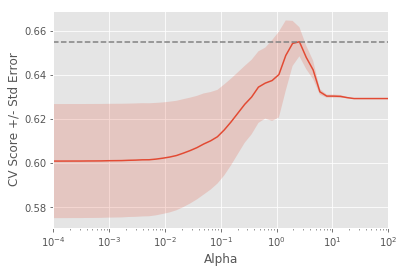

In [115]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 2, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge

ridge = RidgeClassifier(normalize=True)


# Compute scores over range of alphas
for alpha in alpha_space:
    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha

    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv = 5)
  
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))

    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std, alpha_space)

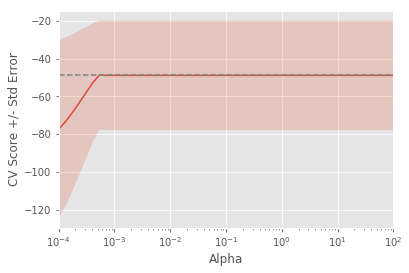

In [116]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 2, 50)
lasso_scores = []
lasso_scores_std = []

# Create a ridge regressor: ridge

lasso = Lasso(normalize=True, max_iter=10000)

y_reshape = np.ravel(y.values.reshape(-1,1))

# Compute scores over range of alphas
for alpha in alpha_space:
    
    # Specify the alpha value to use: ridge.alpha
    lasso.alpha = alpha

    # Perform 10-fold CV: ridge_cv_scores
    lasso_cv_scores = cross_val_score(lasso, X.values, y_reshape, cv = 5)

    # Append the mean of ridge_cv_scores to ridge_scores
    lasso_scores.append(np.mean(lasso_cv_scores))

    # Append the std of ridge_cv_scores to ridge_scores_std
    lasso_scores_std.append(np.std(lasso_cv_scores))

# Display the plot
display_plot(lasso_scores, lasso_scores_std, alpha_space)

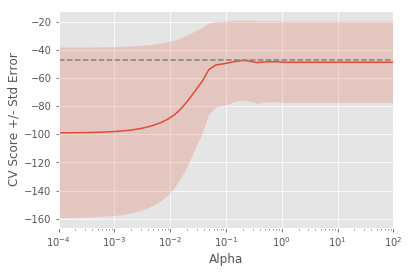

{'alpha': 0.20235896477251575}


In [117]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 2, 50)
results = []

tuned_parameters = [{'alpha': alpha_space}]
n_folds = 5

# Create a lasso regressor
lasso = Lasso(random_state=3, max_iter=10000)

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)

lasso_scores = clf.cv_results_['mean_test_score']
results.append(alpha_space)
results.append(lasso_scores)

lasso_scores_std = clf.cv_results_['std_test_score']
results.append(lasso_scores_std)
# Display the plot
display_plot(lasso_scores, lasso_scores_std, alpha_space)
print(clf.best_params_)

#### Perform Lasso feature selection to determine influential variables.

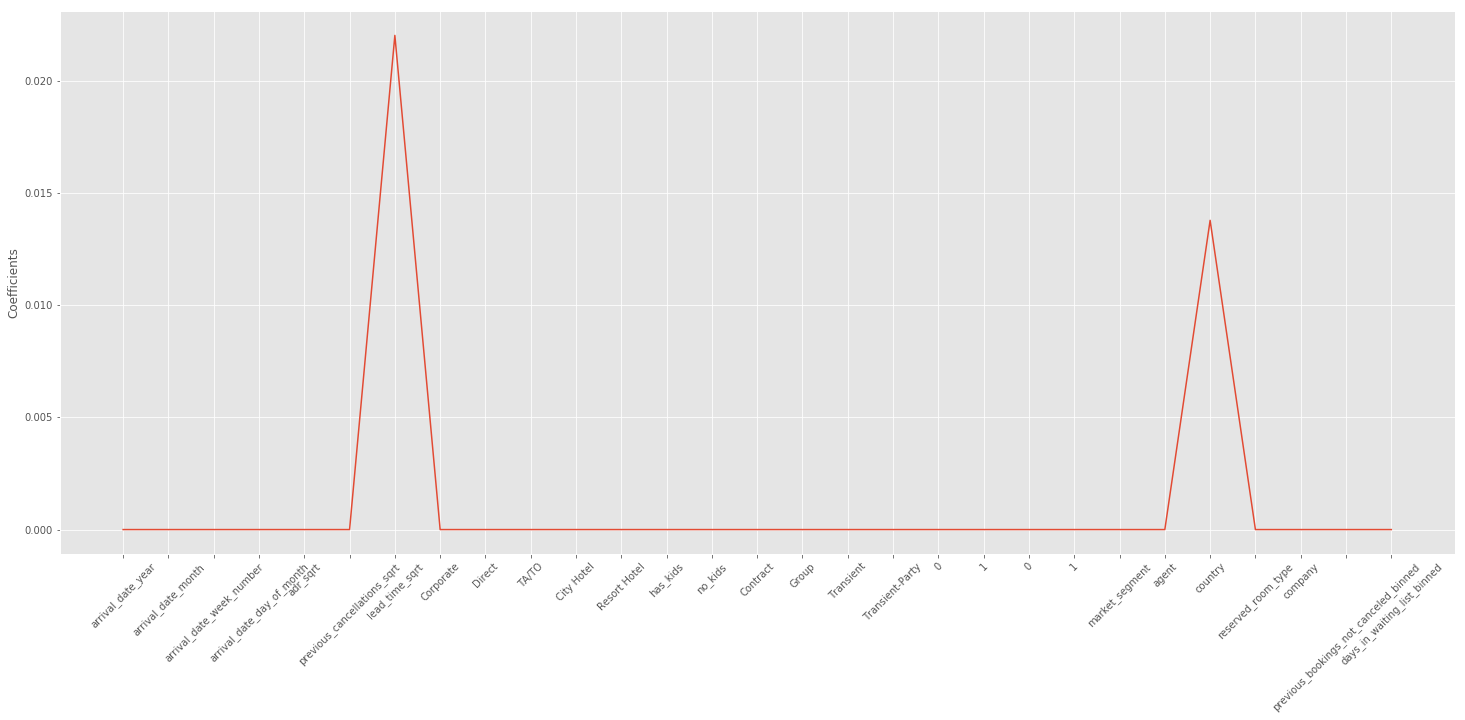

In [118]:
# Lasso for feature selection in scikit learn
#store feature names
from sklearn.linear_model import Lasso
names = X.columns
lasso = Lasso(alpha=0.2)
# extract coef attribute and store
lasso_coef = lasso.fit(X, y).coef_
_ = plt.figure(figsize=(25,10))
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=45)
_ = plt.ylabel('Coefficients')
plt.show()

> It seems that hotels may be a source of overfitting. Since the documentation does not allude to any potential for data leakage among the hotels, this will be ignored for now.

### Random Forests

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Random Forest out of the box
rfc = RandomForestClassifier(random_state=94)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

print("Accuracy Score: ")
print(accuracy_score(y_test, y_pred))

[[13645  1394]
 [ 1918  6881]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     15039
           1       0.83      0.78      0.81      8799

    accuracy                           0.86     23838
   macro avg       0.85      0.84      0.85     23838
weighted avg       0.86      0.86      0.86     23838

Accuracy Score: 
0.8610621696451044


#### Plot Random Forests ROC curve

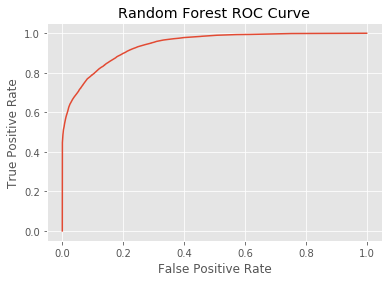

In [120]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve

# plotting the ROC curve
y_pred_prob = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [121]:
print("AUROC Score: ")
print(roc_auc_score(y_test, y_pred_prob))

AUROC Score: 
0.9400741313105682


> The accuracy score and AUROC improved with out of the box RF to 86% and 94% respectively but there could be room for improvement with some parameter tuning.

#### Hyperparameter tuning with RandomizedSearchCV

In [122]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],# Number of trees in random forest
               'max_features': ['auto', 'sqrt'],# Number of features to consider at every split
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],# Maximum number of levels in tree
               'min_samples_split': [2, 5, 10, 20],# Minimum number of samples required to split a node
               'min_samples_leaf': [1, 2, 4, 10, 25],# Minimum number of samples required at each leaf node 
               'bootstrap': [True, False]}# Method of selecting samples for training each tree
 
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, cv = 5, random_state=42)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


In [123]:
# Implementing parameter tuning, Random Forest Tuned (rfc_tnd)
rfc_tnd = RandomForestClassifier(bootstrap = False, n_estimators = 1200, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 50, random_state = 3)
rfc_tnd.fit(X_train,y_train)

# Cross validation
rfc_tnd_cv_score = cross_val_score(rfc_tnd, X_train, y_train, cv=5, scoring='roc_auc')
rfc_tnd_predict = rfc_tnd.predict(X_test)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_tnd_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_tnd_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_tnd_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_tnd_cv_score.mean())

=== Confusion Matrix ===
[[13761  1278]
 [ 2078  6721]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     15039
           1       0.84      0.76      0.80      8799

    accuracy                           0.86     23838
   macro avg       0.85      0.84      0.85     23838
weighted avg       0.86      0.86      0.86     23838



=== All AUC Scores ===
[0.93598748 0.93601607 0.93720689 0.93372449 0.93826916]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9362408187788711


### Plot Tuned Random Forests ROC curve

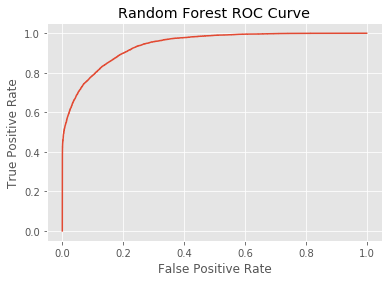

In [124]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve

# plotting the ROC curve
y_pred_prob = rfc_tnd.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [125]:
print(roc_auc_score(y_test, y_pred_prob))

0.9395157845501988


> We see here an overall improvement with Random Forests but virtually no difference with parameter tunining steps. Next we will implement Gradient Boosting to see if this can be improved.

### Gradient Boosting

In [126]:
from sklearn.ensemble import GradientBoostingClassifier

# Learning rate to fit over, keeping hyperparameters from before
lr_list = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators = 1200, learning_rate=learning_rate, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 50, random_state = 3)
    gb_clf.fit(X_train, y_train)
    
    print("Learning rate: ", learning_rate)

    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.01
Accuracy score (validation): 0.861
Learning rate:  0.025
Accuracy score (validation): 0.859
Learning rate:  0.05
Accuracy score (validation): 0.859
Learning rate:  0.075
Accuracy score (validation): 0.858
Learning rate:  0.1
Accuracy score (validation): 0.857
Learning rate:  0.25
Accuracy score (validation): 0.856
Learning rate:  0.5
Accuracy score (validation): 0.854
Learning rate:  0.75
Accuracy score (validation): 0.854
Learning rate:  1
Accuracy score (validation): 0.695


In [127]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Implement gradient boosting with all tuned hyperparameters, including an optimal learning rate of 0.25
gb_clf2 = GradientBoostingClassifier(n_estimators = 1200, learning_rate=0.01, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 50, random_state = 3)
gb_clf2.fit(X_train, y_train)

gb_clf2_cv_score = cross_val_score(gb_clf2, X_train, y_train, cv=5, scoring='roc_auc')
gb_clf2_predict = gb_clf2.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, gb_clf2_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, gb_clf2_predict))
print('\n')
print("=== All AUC Scores ===")
print(gb_clf2_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", gb_clf2_cv_score.mean())

=== Confusion Matrix ===
[[13546  1493]
 [ 1832  6967]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     15039
           1       0.82      0.79      0.81      8799

    accuracy                           0.86     23838
   macro avg       0.85      0.85      0.85     23838
weighted avg       0.86      0.86      0.86     23838



=== All AUC Scores ===
[0.93630227 0.93650004 0.93784495 0.93385547 0.93879803]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.936660153277219


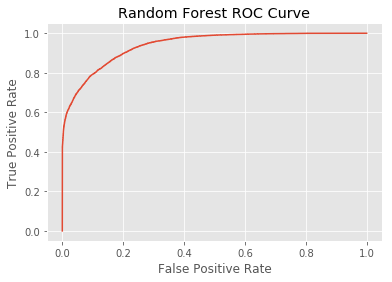

In [128]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve

# plotting the ROC curve
y_pred_prob = gb_clf2.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [129]:
print("Accuracy Score: ")
print(accuracy_score(y_test, gb_clf2_predict))

print("AUROC Score: ")
print(roc_auc_score(y_test, y_pred_prob))

Accuracy Score: 
0.8605168218810303
AUROC Score: 
0.9405173551833764


### Catboost

In [131]:
data.columns

Index(['hotel', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'customer_type', 'kids', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'babies', 'is_repeated_guest',
       'previous_bookings_not_canceled', 'agent', 'company',
       'days_in_waiting_list', 'is_canceled', 'adr_sqrt',
       'previous_cancellations_sqrt', 'lead_time_sqrt',
       'days_in_waiting_list_binned', 'previous_bookings_not_canceled_binned'],
      dtype='object')

In [133]:
catboost_data = data[['hotel', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'agent', 'company', 'customer_type', 'lead_time_sqrt', 'babies', 
       'is_repeated_guest', 'previous_cancellations_sqrt', 'previous_bookings_not_canceled', 
       'days_in_waiting_list', 'adr_sqrt', 'is_canceled']]

catboost_data.agent = catboost_data.agent.astype(str)
catboost_data.company = catboost_data.company.astype(str)

y = catboost_data.is_canceled
X = catboost_data.drop('is_canceled', axis=1)

#Data splitting
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [134]:
categorical_features_indices = np.where((X.dtypes != np.float) & (X.dtypes != np.int))[0]

In [135]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

#Model training
model = CatBoostClassifier(
    custom_loss=['AUC', 'Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [136]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [137]:
#Cross validation
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [138]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=1000,
    random_seed=0,
    custom_loss=['AUC', 'Accuracy'],
    logging_level='Silent',
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=1000,
    random_seed=0,
    custom_loss=['AUC', 'Accuracy'],
    logging_level='Silent',
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=categorical_features_indices,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=categorical_features_indices,
    verbose=False
)

In [139]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [140]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy'],
    logging_level='Silent'
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [141]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 451


In [142]:
from catboost import cv

params = model.get_params()
params['loss_function'] = 'Logloss'
params['iterations'] = 1000
params['custom_loss'] = ['AUC', 'Accuracy']
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=categorical_features_indices),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [143]:
cv_data.head()

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.479754          0.002657            0.479551   
1           1           0.427089          0.001787            0.427484   
2           2           0.410299          0.002670            0.409832   
3           3           0.400096          0.002168            0.399786   
4           4           0.393494          0.002463            0.393210   

   train-Logloss-std  test-AUC-mean  test-AUC-std  test-Accuracy-mean  \
0           0.001286       0.847995      0.002473            0.770694   
1           0.001983       0.870150      0.001118            0.784806   
2           0.004438       0.878057      0.001628            0.787222   
3           0.002640       0.882646      0.001023            0.793716   
4           0.002491       0.886243      0.001337            0.798012   

   test-Accuracy-std  train-Accuracy-mean  train-Accuracy-std  
0           0.003651             0.772588            0.001020  
1           0.002191             0.784726            0.004590  
2           0.002499             0.789041            0.003896  
3           0.002528             0.794421            0.003108  
4           0.001933             0.797875            0.002516

In [144]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
max_auc = np.max(cv_data['test-AUC-mean'])
max_accuracy = np.max(cv_data['test-Accuracy-mean'])
print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)
print(max_auc)
print(max_accuracy)

Best validation Logloss score, not stratified: 0.3331±0.0030 on step 672
0.9205395652255662
0.8343485191710714


/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [145]:
cv_data.iloc[458,]

iterations             458.000000
test-Logloss-mean        0.333766
test-Logloss-std         0.002733
train-Logloss-mean       0.286204
train-Logloss-std        0.001617
test-AUC-mean            0.919426
test-AUC-std             0.001779
test-Accuracy-mean       0.832528
test-Accuracy-std        0.002401
train-Accuracy-mean      0.862828
train-Accuracy-std       0.001373
Name: 458, dtype: float64

## Conclusion

The results of machine learning have yielded a model with an 86% accuracy in predicting booking cancellations and a 94% AUROC, improved from 76% and 80%, respectively. The implications of this work bring a myriad of options to lower overall cancellation rate, increase actualized income and improve customer experience for hotels. With the ability to distinguish between possible cancellations early on, hotels can create a focused effort towards preventing canceled bookings. This would result in an immediate net increase in actualized daily income and would incentivize early outreach to future travelers. One example of this would be to reach out to high risk bookings with discounted packages, perks and early options to customize stay details. Hotels can now be the ones taking advantage of the online travel agency phenomenon by pivoting to meet the market where it is with this cancellation prediction tool.